# Aprendizaje no supervisado - ALGORITMO DE CLUSTERING K-MEANS (K-MEDIAS)

### INTRODUCCIÓN   

Los modelos de clustering pretenden agrupar los datos en "clusters" o grupos distintos. Esto puede servir tanto como un punto de vista interesante en un análisis, o puede servir como una característica en un algoritmo de aprendizaje supervisado.       

Si imaginamos un entorno social en el que grupos de personas discuten en diferentes círculos alrededor de una sala. Cuando se mira hacia la sala por primera vez, sólo se ve un grupo de personas. Mentalmente se podría empezar a colocar puntos en el centro de cada grupo de personas y nombrar ese punto como un identificador único. De este modo, podrá referirse a cada grupo con un nombre único para describirlos. Esto es esencialmente lo que hace el algoritmo **k-means** con los datos. 


<img src="/home/jordi/Documentos/Ribera/Curso_25_26/CEIABD/CEIABD_25_26/SISTEMAS_APRENDIZAJE_AUTOMATICO_25_26/NOTEBOOKS DEL AULA/Aprendizaje No Supervisado/img/KMEANS1.png">   

En la parte izquierda del diagrama, se puede ver 2 conjuntos distintos de puntos sin etiquetar y coloreados como puntos de datos similares. El ajuste de un modelo **k-means** a estos datos (lado derecho) puede revelar 2 grupos distintos (mostrados en círculos y colores distintos). 

En dos dimensiones, es fácil para el ser humano dividir estos conglomerados, pero con más dimensiones, es necesario utilizar un modelo.

### Analizando un primer ejemplo - Viviendas de California   

#### El dataset   

Para este ejemplo inicial, se van a usar los [precios de viviendas de California](https://www.kaggle.com/datasets/camnugent/california-housing-prices?resource=download). Se tomarán los datos de localización (latitud y longitud), así como el valor medio de la vivienda y el número de habitantes. Se agruparán las casas por localidades y se quiere observar cómo fluctúan los precios de la vivienda en California.    
El dataset se llama ‘housing.csv’ y se encuentra en el directorio *datasets*.

In [8]:
import pandas as pd

home_data = pd.read_csv('/home/jordi/Documentos/Ribera/Curso_25_26/CEIABD/CEIABD_25_26/SISTEMAS_APRENDIZAJE_AUTOMATICO_25_26/NOTEBOOKS DEL AULA/Aprendizaje No Supervisado/datasets/housing.csv', usecols = ['longitude', 'latitude', 'median_house_value','population'])
home_data.head()

,longitude,latitude,population,median_house_value
0,-122.23,37.88,322.0,452600.0
1,-122.22,37.86,2401.0,358500.0
2,-122.24,37.85,496.0,352100.0
3,-122.25,37.85,558.0,341300.0
4,-122.25,37.85,565.0,342200.0


Los datos incluyen 4 variables que se han seleccionado utilizando el parámetro usecols:

- **longitud**: Valor que representa la distancia a la que se encuentra una casa. Los valores más altos representan casas que están más al Oeste.   
- **latitud**: Valor que representa la distancia al norte de una casa. Los valores más altos representan casas que están más al norte.    
- **median_house_value**: El precio medio de la vivienda dentro de una manzana medido en USD.   
- **population**: Número de habitantes que residen en una manzana.

#### Visualización de datos    

Empezamos con la visualización de los datos de vivienda. Se puede observar los datos de localización con un mapa de calor basado en el precio medio de una manzana. Para ello se utiliza Seaborn, creando rápidamente los gráficos.

<Axes: xlabel='longitude', ylabel='latitude'>

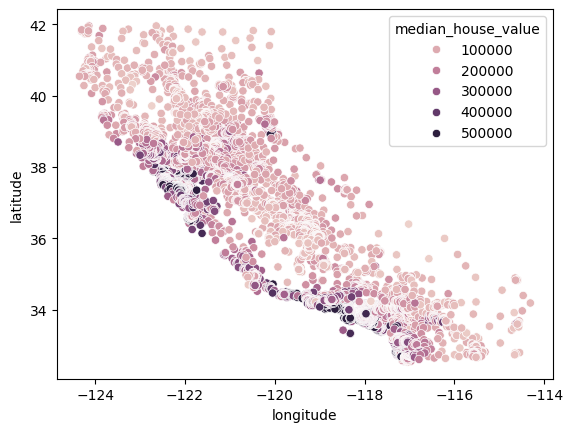

In [9]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


sns.scatterplot(data = home_data, x = 'longitude', y = 'latitude', hue = 'median_house_value')

/tmp/ipykernel_49722/2824053598.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)


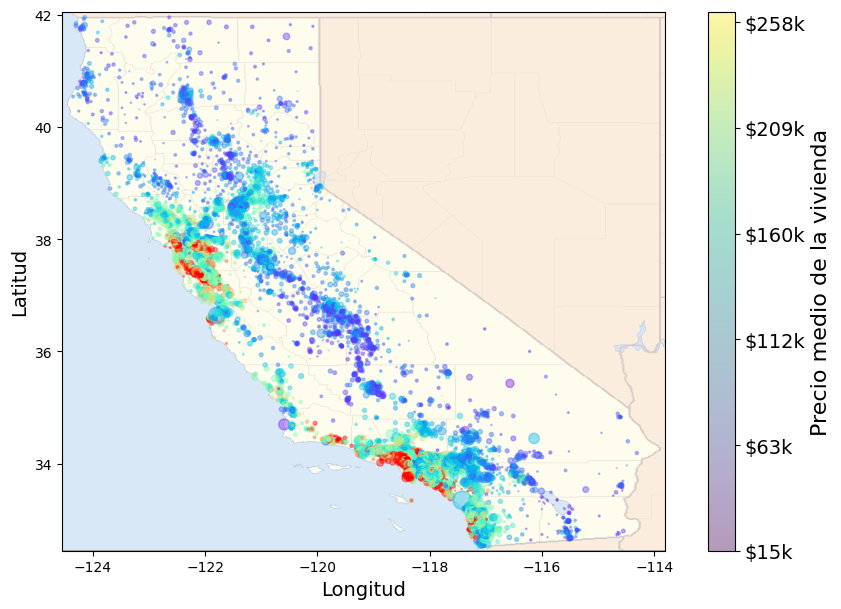

In [11]:
from PIL import Image
import requests
from io import BytesIO

cali_image_url = 'https://upload.wikimedia.org/wikipedia/commons/1/1b/California_Locator_Map.PNG'

r = requests.get(cali_image_url, headers={"User-Agent": "Mozilla/5.0"})
r.raise_for_status()

cali = np.array(Image.open(BytesIO(r.content)))

# plot the populations with density and colors
ax = home_data.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4,
    s = home_data["population"]/200, figsize = (11,7),
    c = "median_house_value", cmap = plt.get_cmap("rainbow"), colorbar = False,
    sharex = True)

# Grafica la imagen de California con los datos superpuestos
plt.imshow(cali, extent=[-124.55, -113.80, 32.45, 42.05], alpha = 0.4)
plt.ylabel("Latitud", fontsize=14)
plt.xlabel("Longitud", fontsize=14)

prices = home_data["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(cmap = "rainbow")
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Precio medio de la vivienda', fontsize=16)

Se puede observar que la mayoría de las casas caras están en la costa oeste de California, con diferentes zonas que tienen grupos de casas de precio moderado. Esto es de esperar, ya que normalmente las propiedades situadas frente al mar valen más que las casas que no están en la costa. 

#### Normalización de los datos   

Cuando se trabaja con algoritmos basados en la **distancia**, como este caso de *k-Means*, es necesario normalizar los datos. Si no se normalizan los datos, las variables con diferente escala se ponderarán de **forma diferente** en la fórmula de distancia que se está intentando optimizar durante el entrenamiento.    

Por ejemplo, si se incluye el precio en el clúster, además de la latitud y la longitud, el precio tendría un impacto desproporcionado en las optimizaciones porque su escala es significativamente mayor y más amplia que las variables de localización acotadas. 

En primer lugar, por tanto, se configuran las divisiones de entrenamiento y prueba utilizando ***train_test_split*** de sklearn. 

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(home_data[['latitude', 'longitude']], home_data[['median_house_value']], test_size=0.33, random_state=0)

A continuación, normalizamos los datos de entrenamiento y de prueba utilizando el método `preprocessing.normalize()` de sklearn. 

In [13]:
from sklearn import preprocessing

X_train_norm = preprocessing.normalize(X_train)
X_test_norm = preprocessing.normalize(X_test)

#### Ajuste y evaluación del modelo   

Para la primera iteración, se elige arbitrariamente un número de conglomerados (denominado **k**) de 3.    
Construir y ajustar modelos en sklearn es muy sencillo:    
- Se crea una instancia de KMeans, 
- Se define el número de clusters utilizando el atributo `n_clusters`, 
- Se establece `n_init`, que define el número de iteraciones que el algoritmo ejecutará con diferentes semillas centroides, en "auto", y 
- Se establecere `random_state` en 0 para obtener el mismo resultado cada vez que ejecutemos el código.     

A continuación, ya se puede ajustar el modelo a los datos de entrenamiento normalizados utilizando el método `fit()`.

In [15]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3, random_state = 0, n_init='auto')
kmeans.fit(X_train_norm)

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,0
,copy_x,True
,algorithm,'lloyd'


Una vez ajustados los datos, es posible acceder a las etiquetas desde el atributo `labels_`.    
A continuación, se visualizan los datos que se acaban de ajustar. 

<Axes: xlabel='longitude', ylabel='latitude'>

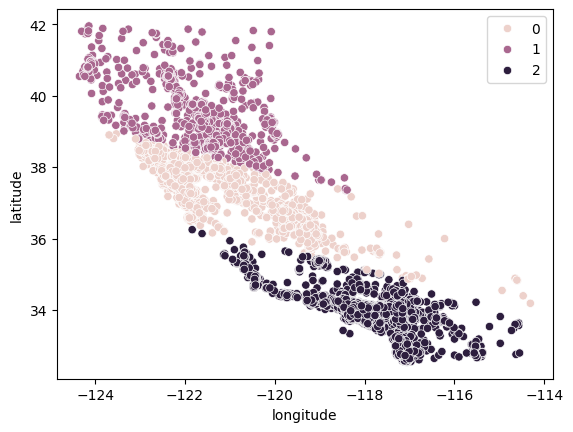

In [16]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = kmeans.labels_)

Se observa ahora que los datos están claramente divididos en 3 grupos distintos (Norte de California, Centro de California y Sur de California). También se puede observar la distribución de los precios medios de la vivienda en estos 3 grupos utilizando un diagrama de caja. 

<Axes: ylabel='median_house_value'>

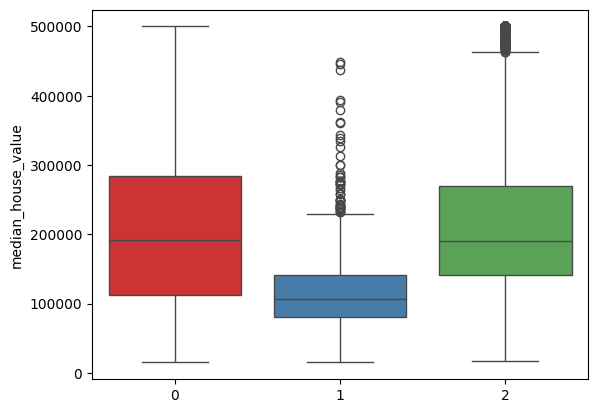

In [23]:
sns.boxplot(x = kmeans.labels_, y = y_train['median_house_value'], hue=kmeans.labels_, legend=False, palette="Set1")

Se observa claramente que las agrupaciones del norte y del sur tienen distribuciones similares de valores medios de la vivienda (agrupaciones 0 y 2) que son superiores a los precios de la agrupación central (agrupación 1). 

Es posible evaluar el rendimiento del algoritmo de agrupación utilizando la puntuación **Silhouette**, que es una parte de `sklearn.metrics` en la que una puntuación más baja representa un mejor ajuste.   

#### Elección del número óptimo de clusters   

El punto débil de la agrupación k-means es que no es posible conocer *cuantos clusters necesitamos* con sólo ejecutar el modelo.    
Es necesario probar rangos de valores y tomar una decisión sobre el mejor valor de **k**. Normalmente se toma una decisión utilizando el denominado ***método del codo*** para determinar el número óptimo de agrupaciones en el que no se sobreajuste los datos con demasiados grupos y tampoco los infraajustamos con muy pocos. 

Se genera el siguiente bucle para probar y almacenar los resultados de diferentes modelos, de forma que sea posible tomar una decisión sobre el mejor número de clusters.

In [ ]:
from sklearn.metrics import silhouette_score

K = range(2, 8)
fits = []
score = []


for k in K:

    # entrenamos el modelo para el valor actual de k con los datos de entrenamiento
    model = KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(X_train_norm)
    
    # añadimos el modelo a  fits
    fits.append(model)
    
    # Añadimos el silhouette score a score
    score.append(silhouette_score(X_train_norm, model.labels_, metric='euclidean'))

A continuación, se procede a examinar visualmente algunos valores diferentes de k. 

Primero se analiza para k = 2.

<Axes: xlabel='longitude', ylabel='latitude'>

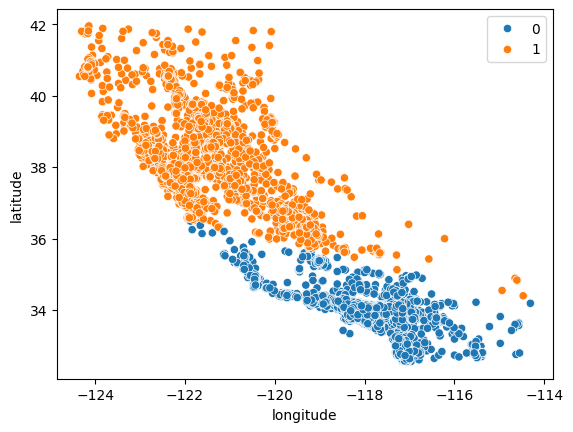

In [26]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[0].labels_)

El modelo hace un buen trabajo al dividir el Estado en dos mitades, pero probablemente no capta suficientes matices del mercado inmobiliario californiano.    

A continuación, se toma k = 4.

<Axes: xlabel='longitude', ylabel='latitude'>

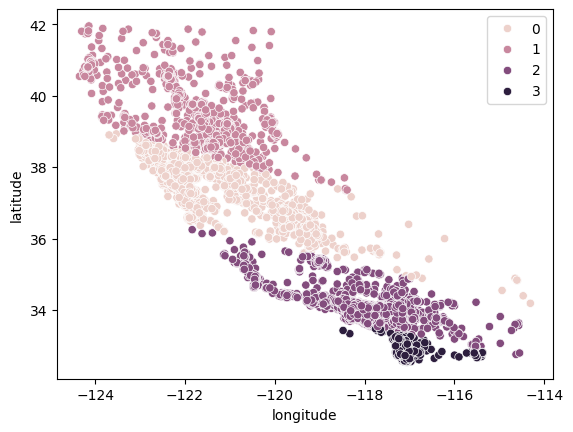

In [27]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[2].labels_)

Se observa que este gráfico agrupa California en conjuntos más lógicos en todo el estado en función de lo al norte o al sur que se encuentren las casas en el estado. Lo más probable es que este modelo capte más matices del mercado de la vivienda a medida que nos desplazamos por el Estado. 

Por último, analizamos para k = 7.

<Axes: xlabel='longitude', ylabel='latitude'>

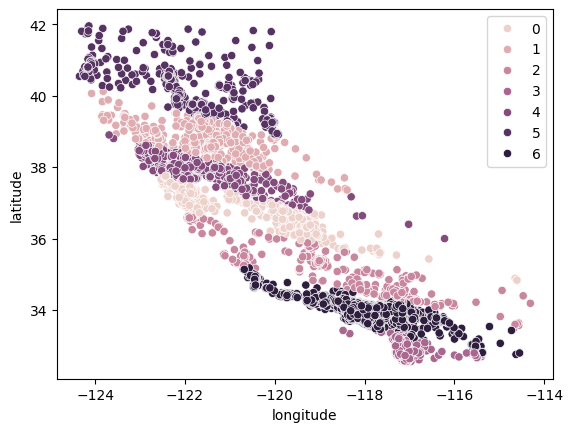

In [31]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[5].labels_)

El último gráfico parece tener demasiados grupos. Se ha sacrificado la facilidad de interpretación de los clusters para obtener un resultado de geoagrupación "más preciso". 

Normalmente, a medida que se aumenta el valor de **k**, se suele observar mejoras en los clusters y en lo que representan, hasta cierto punto. Entonces se empieza a ver rendimientos decrecientes o incluso peores resultados. Es posible ver esto visualmente para ayudar a tomar una decisión sobre el valor de **k** utilizando un ***gráfico de codo*** donde el eje *y* es una medida de la bondad del ajuste y el eje *x* es el valor de **k**. 

<Axes: >

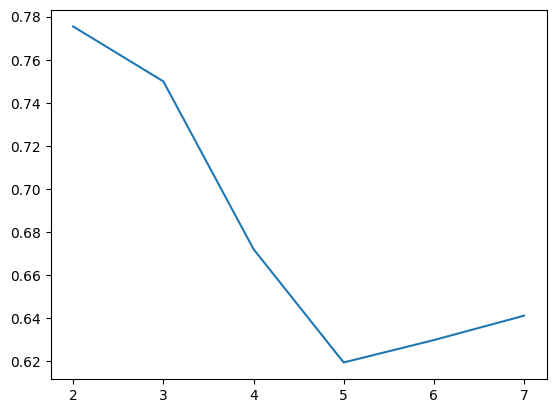

In [32]:
sns.lineplot(x = K, y = score)

Normalmente, se suele elegir el punto en el que las mejoras de rendimiento empiezan a aplanarse o a empeorar. Vemos que para *k = 5* es probablemente lo mejor que se puede tomar sin llegar a provocar un sobreajuste. 

También se puede ver que los clusters hacen un trabajo relativamente bueno al dividir California en distintos clusters y estos clusters se asignan relativamente bien a diferentes rangos de precios, tal y como se ve a continuación:

<Axes: xlabel='longitude', ylabel='latitude'>

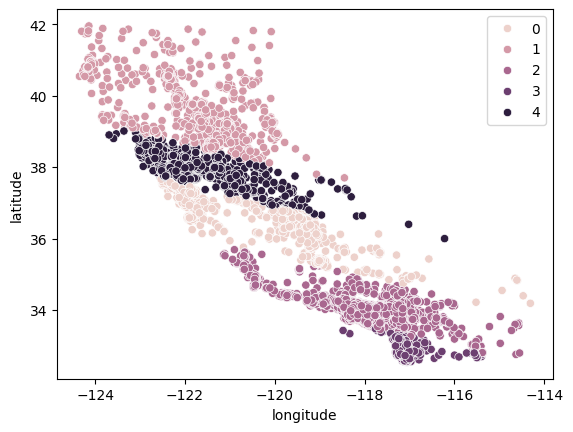

In [33]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[3].labels_)

<Axes: ylabel='median_house_value'>

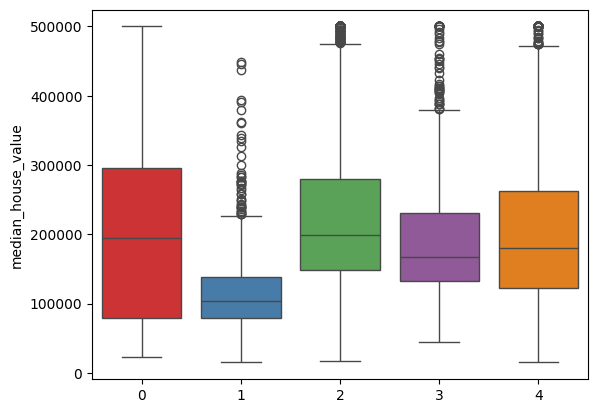

In [35]:
sns.boxplot(x = fits[3].labels_, y = y_train['median_house_value'], hue=fits[3].labels_, legend=False, palette="Set1")

## Segundo ejemplo. Análisis de datos sintéticos.

Carga de librerías y adecuación de ploteado de gráficos

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; 
sns.set_theme()  # para mejorar el estilo de los gráficos
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Generando datos sintéticos

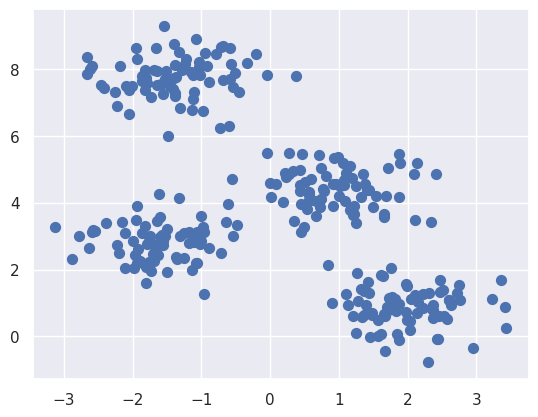

In [37]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,  # genera 4 grupos de datos, con 300 muestras cada uno
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

## Aplicación del método del codo para calcular **K**

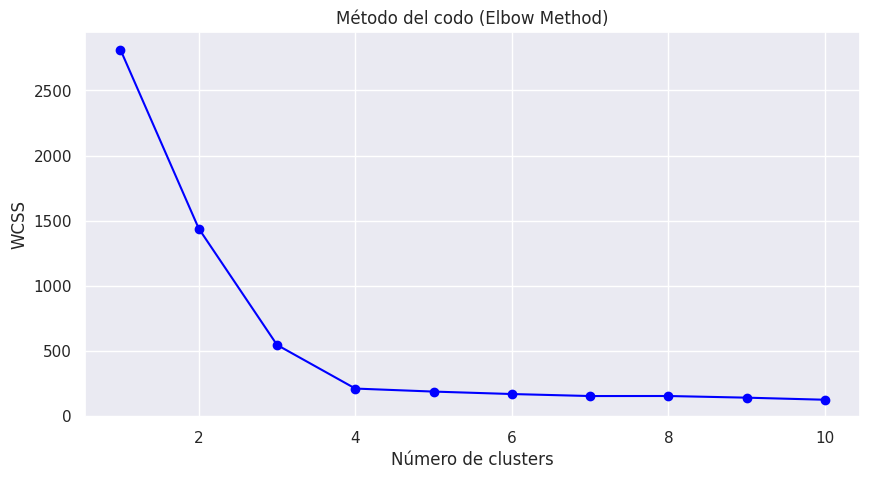

In [38]:
wcss = [] # vector para guardar la suma de los cuadrados de las distancias.
for i in range(1,11): # Bucle para probar diferentes números de clusters de 1 a 10 y generar el gráfico del método del codo
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42) # k-means++ es un algoritmo para inicializar los centroides.random_state es la semilla para el generador de números aleatorios
    kmeans.fit(X)                               # Entrenamos el modelo con las dos últimas columnas del dataset
    wcss.append(kmeans.inertia_)      # Añadimos el valor de inertia_ , que es el atributo que nos da la suma de los cuadrados de las distancias de cada punto al centroide más cercano.

plt.figure(figsize=(10,5))
plt.plot(range(1,11), wcss, marker='o', color='blue') 
plt.title('Método del codo (Elbow Method)')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS') # Suma de cuadrados dentro del cluster
plt.show()

Ubicación de los 11 centroides analizados

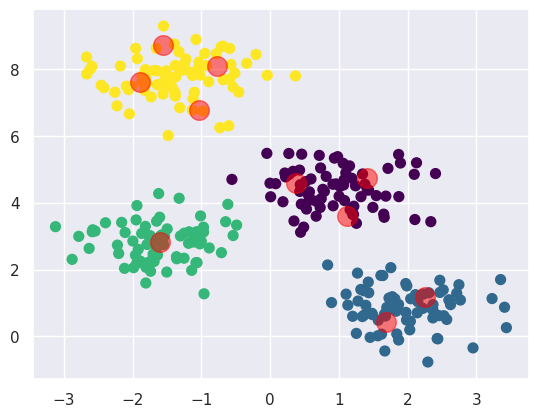

In [39]:
plt.scatter(X[:, 0], X[:, 1], c=y_true, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);

## Construcción y ejecución del modelo final (K=4)

In [40]:

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

### Ploteado y ubicación de centroides

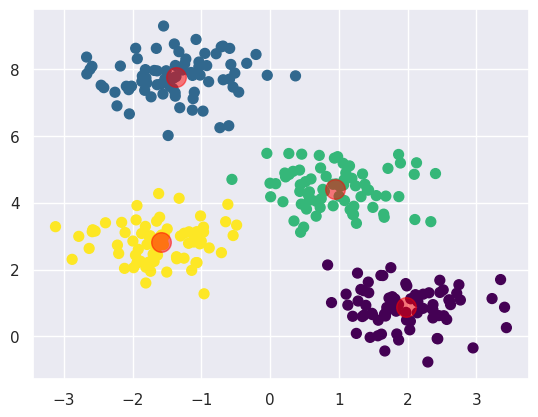

In [41]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);

## Tercer ejemplo: K-Means sobre el dataset IRIS

Importamos librerías

In [2]:
from sklearn.cluster import KMeans
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt

Cargamos dataset

In [3]:
iris = datasets.load_iris()

Particionado de datos (variables de entrada y variable de salida)  
Quitamos la variable de salida ('Target') donde se halla la especie etiquetada para poder realizar el clustering

In [4]:
X_iris = iris.data
Y_iris = iris.target

In [5]:
x = pd.DataFrame(iris.data, columns = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width'])
y = pd.DataFrame(iris.target, columns = ['Target'])
x.head(5)

,Sepal Length,Sepal Width,Petal Length,Petal Width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### Localización de **K** aplicando el método del codo

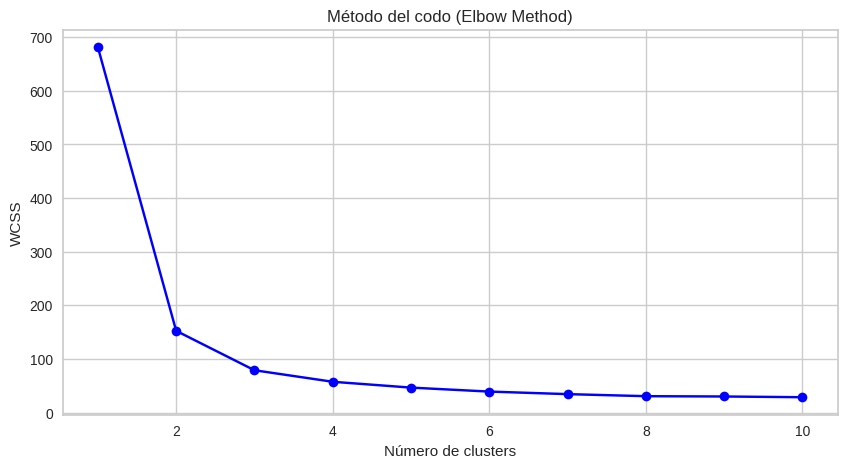

In [6]:
wcss = [] # vector para guardar la suma de los cuadrados de las distancias.
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42) # k-means++ es un algoritmo para inicializar los centroides.random_state es la semilla para el generador de números aleatorios
    kmeans.fit(x)                               # Entrenamos el modelo con las dos últimas columnas del dataset
    wcss.append(kmeans.inertia_)      # Añadimos el valor de inertia_ , que es el atributo que nos da la suma de los cuadrados de las distancias de cada punto al centroide más cercano.

plt.figure(figsize=(10,5))
plt.plot(range(1,11), wcss, marker='o', color='blue') 
plt.title('Método del codo (Elbow Method)')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS') #w Suma de cuadrados dentro del cluster
plt.show()

Ploteado de los 11 posibles centroides

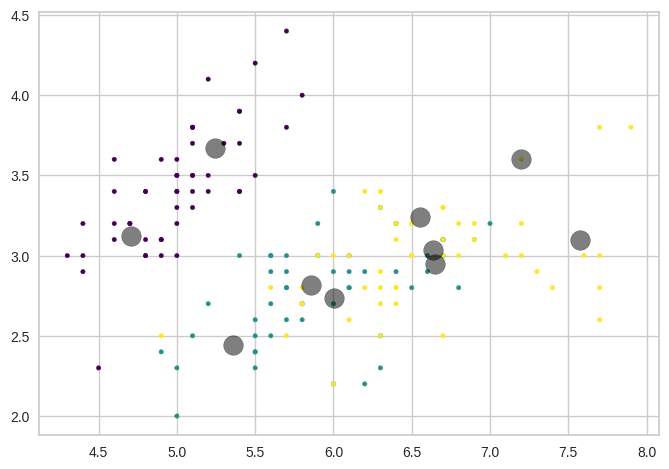

In [7]:
plt.scatter(x['Sepal Length'], x['Sepal Width'], c=y['Target'], s=10, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

### Predicciones usando el PÉTALO

Text(0, 0.5, 'Anchura del pétalo')

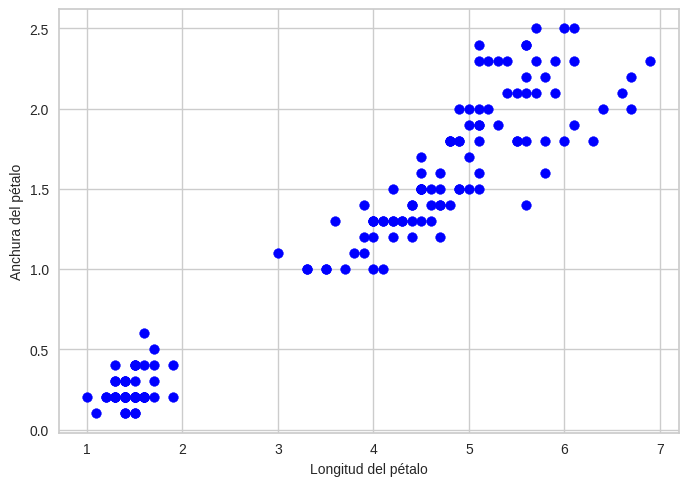

In [8]:
plt.scatter(x['Petal Length'], x['Petal Width'], c = 'blue')
plt.xlabel('Longitud del pétalo', fontsize = 10)
plt.ylabel('Anchura del pétalo', fontsize = 10)

In [9]:
model = KMeans(n_clusters = 3, max_iter = 1000)
model.fit(x)
y_labels = model.labels_

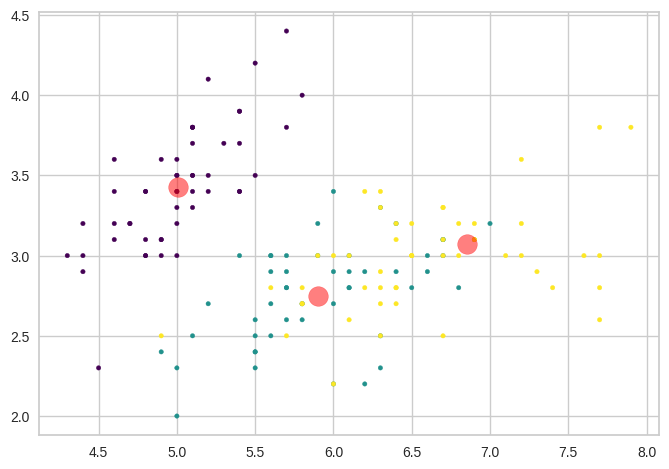

In [10]:
plt.scatter(x['Sepal Length'], x['Sepal Width'], c=y['Target'], s=10, cmap='viridis')
centers = model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)

In [11]:
y_kmeans = model.predict(x)
print('Predicciones', y_kmeans)

Predicciones [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 2 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1]


In [12]:
from sklearn import metrics

accuracy = metrics.adjusted_rand_score(Y_iris, y_kmeans) #Y_iris contiene la columna 'Target' con las etiquetas de las especies
print(accuracy)

0.7302382722834697


Text(0, 0.5, 'Anchura del pétalo')

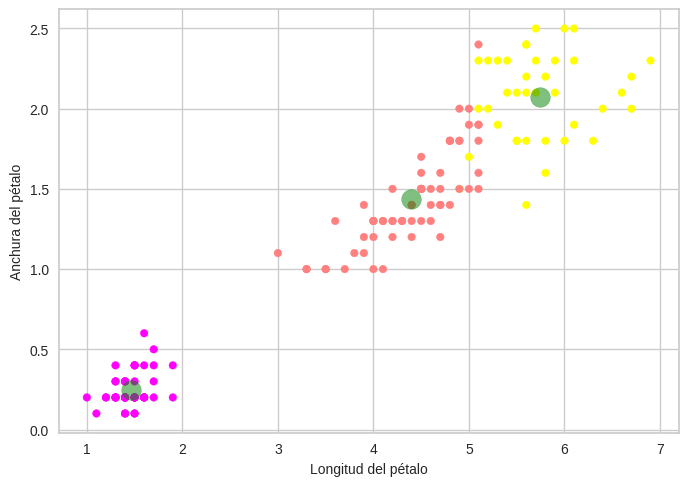

In [13]:
plt.scatter(x['Petal Length'], x['Petal Width'], c = y_kmeans, s = 30, cmap = 'spring')
centers = model.cluster_centers_
plt.scatter(centers[:, 2], centers[:, 3], c='green', s=200, alpha=0.5)
plt.xlabel('Longitud del pétalo', fontsize = 10)
plt.ylabel('Anchura del pétalo', fontsize = 10)

### Predicciones usando el SÉPALO

Text(0, 0.5, 'Anchura del sépalo')

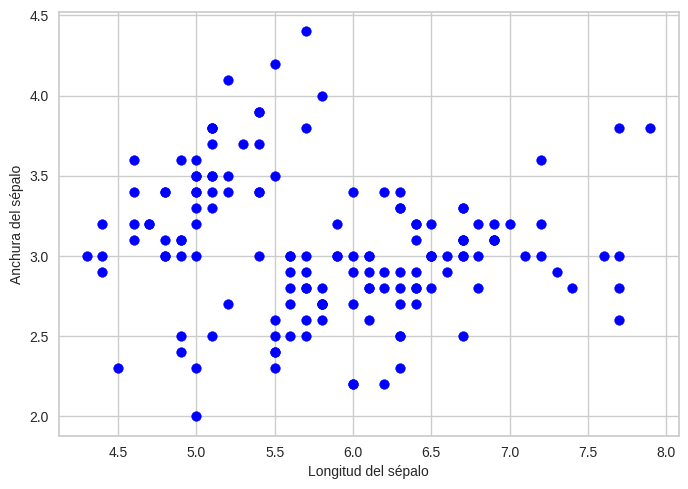

In [14]:
plt.scatter(x['Sepal Length'], x['Sepal Width'], c = 'blue')
plt.xlabel('Longitud del sépalo', fontsize = 10)
plt.ylabel('Anchura del sépalo', fontsize = 10)

In [15]:
model_1 = KMeans(n_clusters = 3, max_iter = 1000)
model_1.fit(x)
y_labels = model_1.labels_

In [16]:
y_kmeans_1 = model_1.predict(x)
print('Predicciones', y_kmeans_1)

Predicciones [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1
 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1
 1 0]


In [17]:
accuracy_1 = metrics.adjusted_rand_score(Y_iris, y_kmeans_1)
print(accuracy_1)

0.7163421126838476


## Análisis del índice "Silhouette Score" para ayudar a determinar el valor de K.       

La ***Silhouette Score*** es una métrica que permite evaluar la calidad de los clústeres generados mediante algoritmos de clustering basados en la distancia euclídea,como es el caso de **k-means**.     

Cuantifica la relación que existe entre la separación de los diferentes clústeres y la similitud entre los puntos de un mismo clúster en un valor que varía entre -1 y 1. Los valores cercanos a 1 indican la mejor separación de los clústeres y los cercanos a -1 la peor. Por tanto, esta información que se puede utilizar para seleccionar el número óptimo de clústeres en **k-means**

Es decir, esta métrica (transformada aquí en función) devuelve el número de clústers recomendados después de ejecutar el algoritmo K-Means para un conjunto concreto de clusters

### Silhouette Score y gráficos de Silhouette:   

- La **silhouette score** para un conjunto de puntos de datos de muestra se utiliza para medir lo densos y bien separados que están los clústers.
- La **silhouette score** tiene en cuenta la distancia intraclúster entre la muestra y otros puntos de datos dentro del mismo clúster (a) y la distancia interclúster entre la muestra y el siguiente clúster más cercano (b).
- La **silhouette score** se sitúa dentro del intervalo [-1, 1].
    - Una **silhouette score** de 1 significa que los clústers son muy densos y están bien separados. 
    - La puntuación de 0 significa que los clústers se solapan. 
    - La puntuación inferior a 0 significa que los datos pertenecientes a los clústers pueden ser erróneos/incorrectos.
- Los gráficos de silueta pueden utilizarse para seleccionar el valor más óptimo de K (nº de clústers) en la agrupación K-means.
    - Los aspectos a tener en cuenta en los gráficos de silueta son las puntuaciones de los clústers por debajo de la puntuación media de la silueta, las grandes fluctuaciones en el tamaño de los clústers y también el grosor del gráfico de silueta.

### Cómo elegir K mirando los gráficos silhouette

Cuando se prueban varios K (por ejemplo K = 2…10) se debe observar:

✅ A) “Media silhouette” máxima (o casi máxima)

- Normalmente se elige el K cuyo silhouette medio es más alto.   
    Si K=2 da 0.62 y K=3 da 0.61
    👉 elegir K=2 puede ser mejor (más simple, igual de bueno)

- Regla práctica:
📌 Seleccionar el K más pequeño que esté cerca del máximo.

✅ B) Clústeres con buen grosor y sin valores negativos

En un silhouette plot:
- ada clúster aparece como una “barra” vertical (una franja). Dentro, están ordenados por silhouette

Se busca:

- Franjas anchas con valores silhouette altos
- Pocos o ningún punto por debajo de 0
- Clústeres relativamente equilibrados en tamaño (no 1 enorme + 1 mini si no tiene sentido)

📌 Si un K genera muchos valores negativos → mala elección.

✅ C) Separación clara entre clústeres

En el gráfico suele aparecer una línea vertical con la media silhouette.
Un buen K tiene:
- la mayoría de puntos a la derecha de 0
- muchos puntos cerca o por encima de la media
- clústeres sin “colas” grandes hacia 0 o negativo

In [21]:
import importlib
import AUXfunctions as au
importlib.reload(au)

print("Número de clústers recomendados: ", au.silhouette(X_iris))

Número de clústers recomendados:  2


Para n_clusters = 2 La media de silhouette_score es:  0.6810461692117462
Para n_clusters = 3 La media de silhouette_score es:  0.551191604619592
Para n_clusters = 4 La media de silhouette_score es:  0.49535632852884987


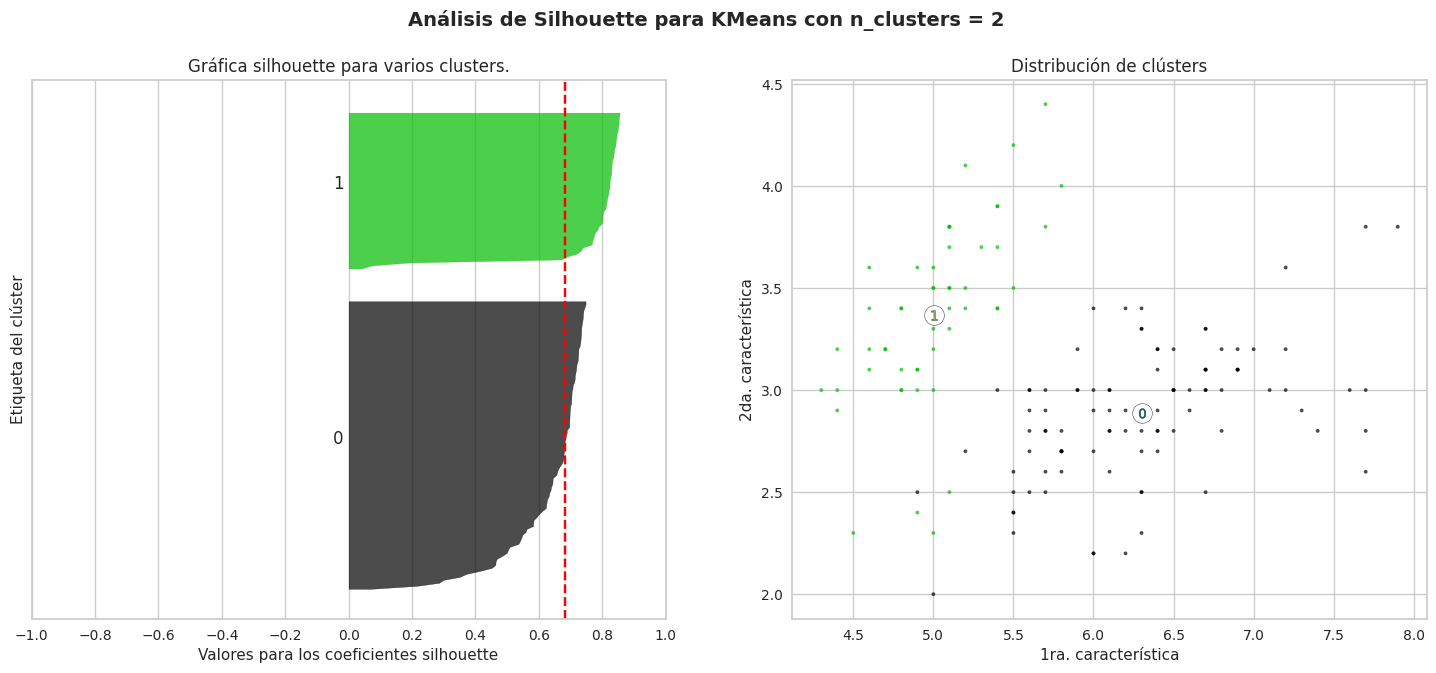

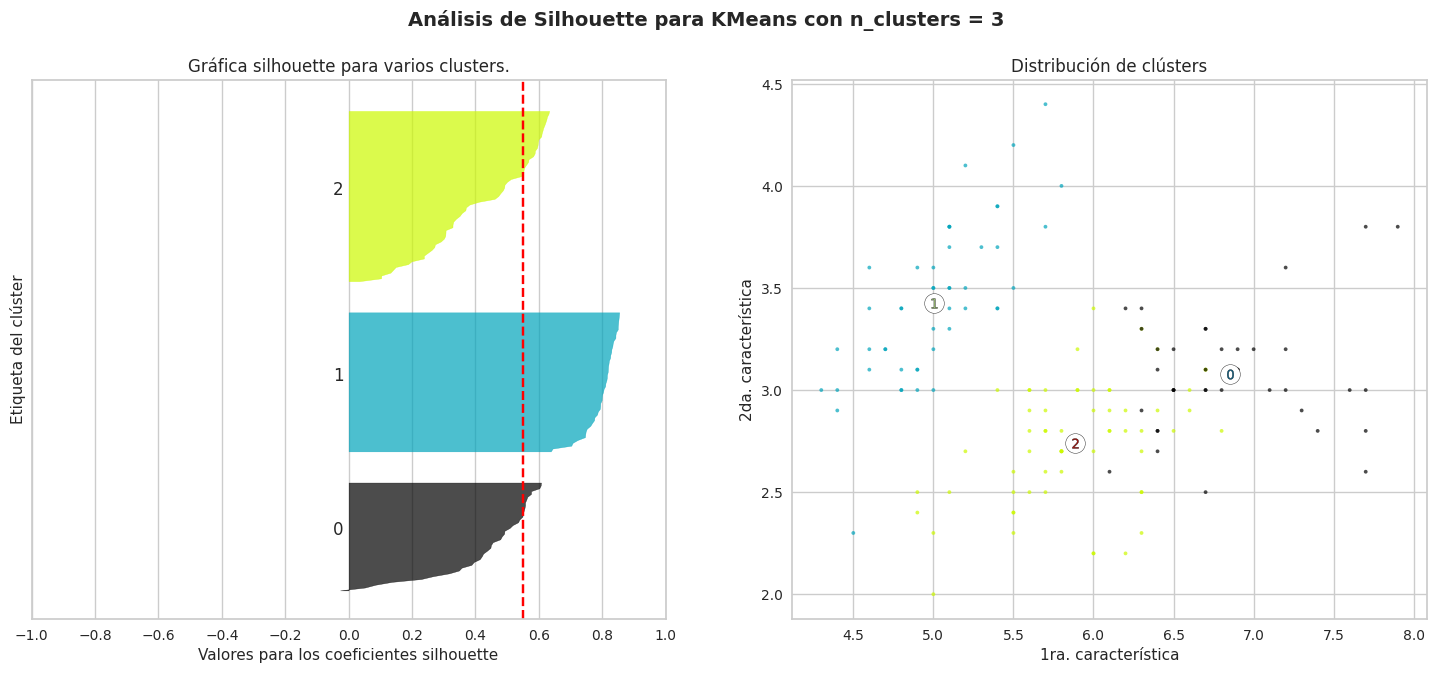

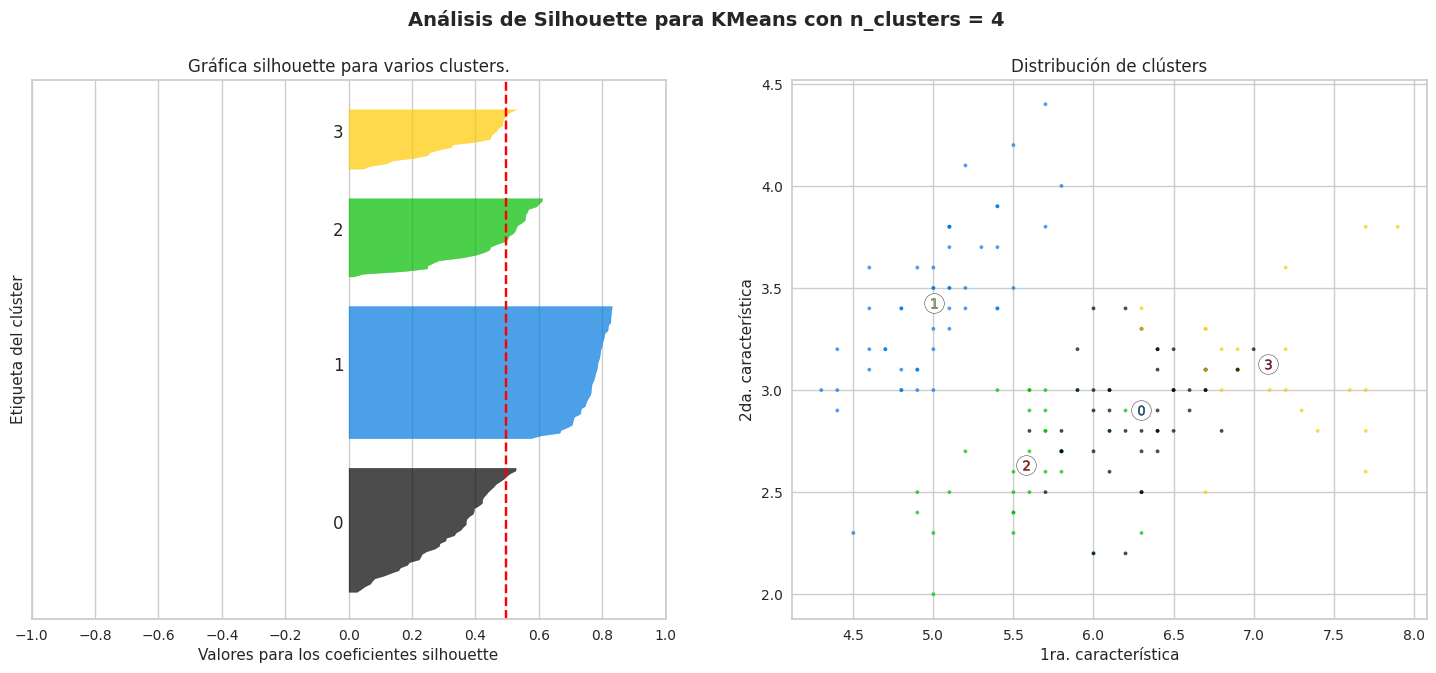

In [22]:
au.plot_silhouette(X_iris, 4)

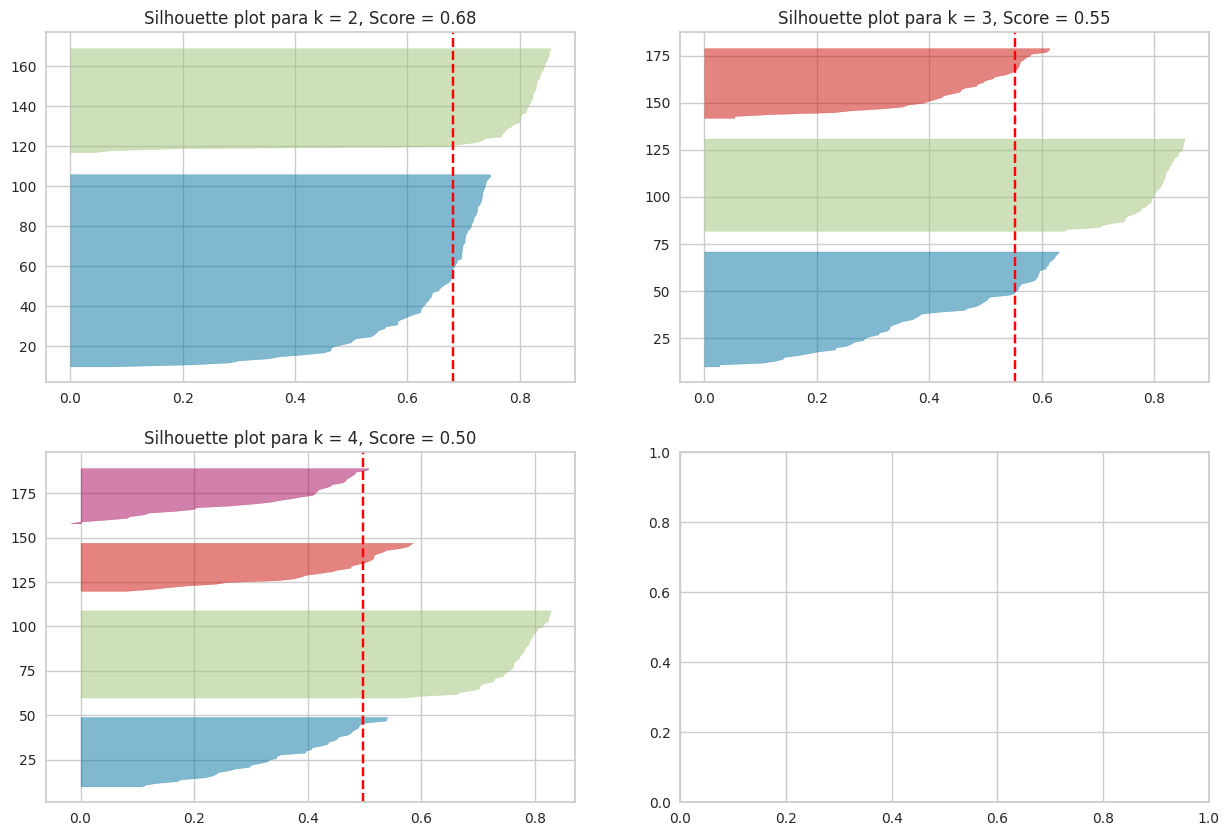

In [19]:
au.silhouette_plot(X_iris, 4)

Text(0, 0.5, 'Anchura del sépalo')

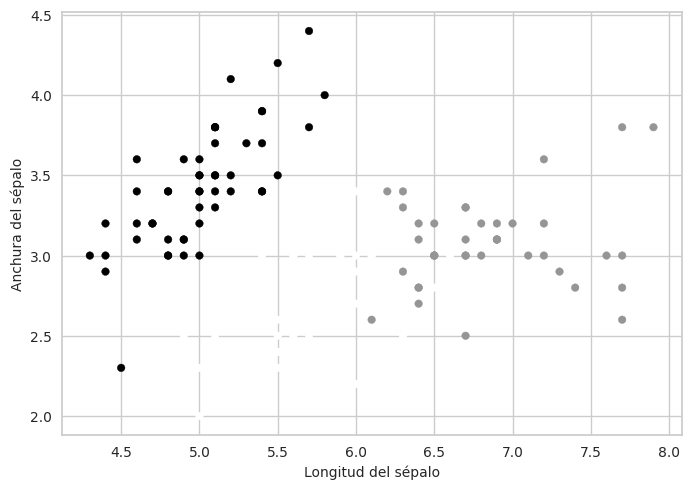

In [20]:
plt.scatter(x['Sepal Length'], x['Sepal Width'], c = y_kmeans_1, s = 30)
plt.xlabel('Longitud del sépalo', fontsize = 10)
plt.ylabel('Anchura del sépalo', fontsize = 10)

## Último ejemplo: Clasificación de dígitos con K-Means

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits

Cargamos el dataset DIGITS

In [25]:
digits = load_digits()
data = digits.data
print(data.shape)

(1797, 64)


Invertimos los colores para mejor visualización

In [26]:
data = 255-data

Fijamos la semilla para que los resultados obtenidos aquí sean repetibles

In [27]:
np.random.seed(1)

Análisis del índice "Silhouette Score" para ayudar a determinar el valor de K.    
La función devuelve el número de clústers recomendados después de ejecutar el algoritmo K-Means para un conjunto concreto de clusters

In [28]:

print("Número de clústers recomendados : ", au.silhouette(data,12))

Número de clústers recomendados :  9


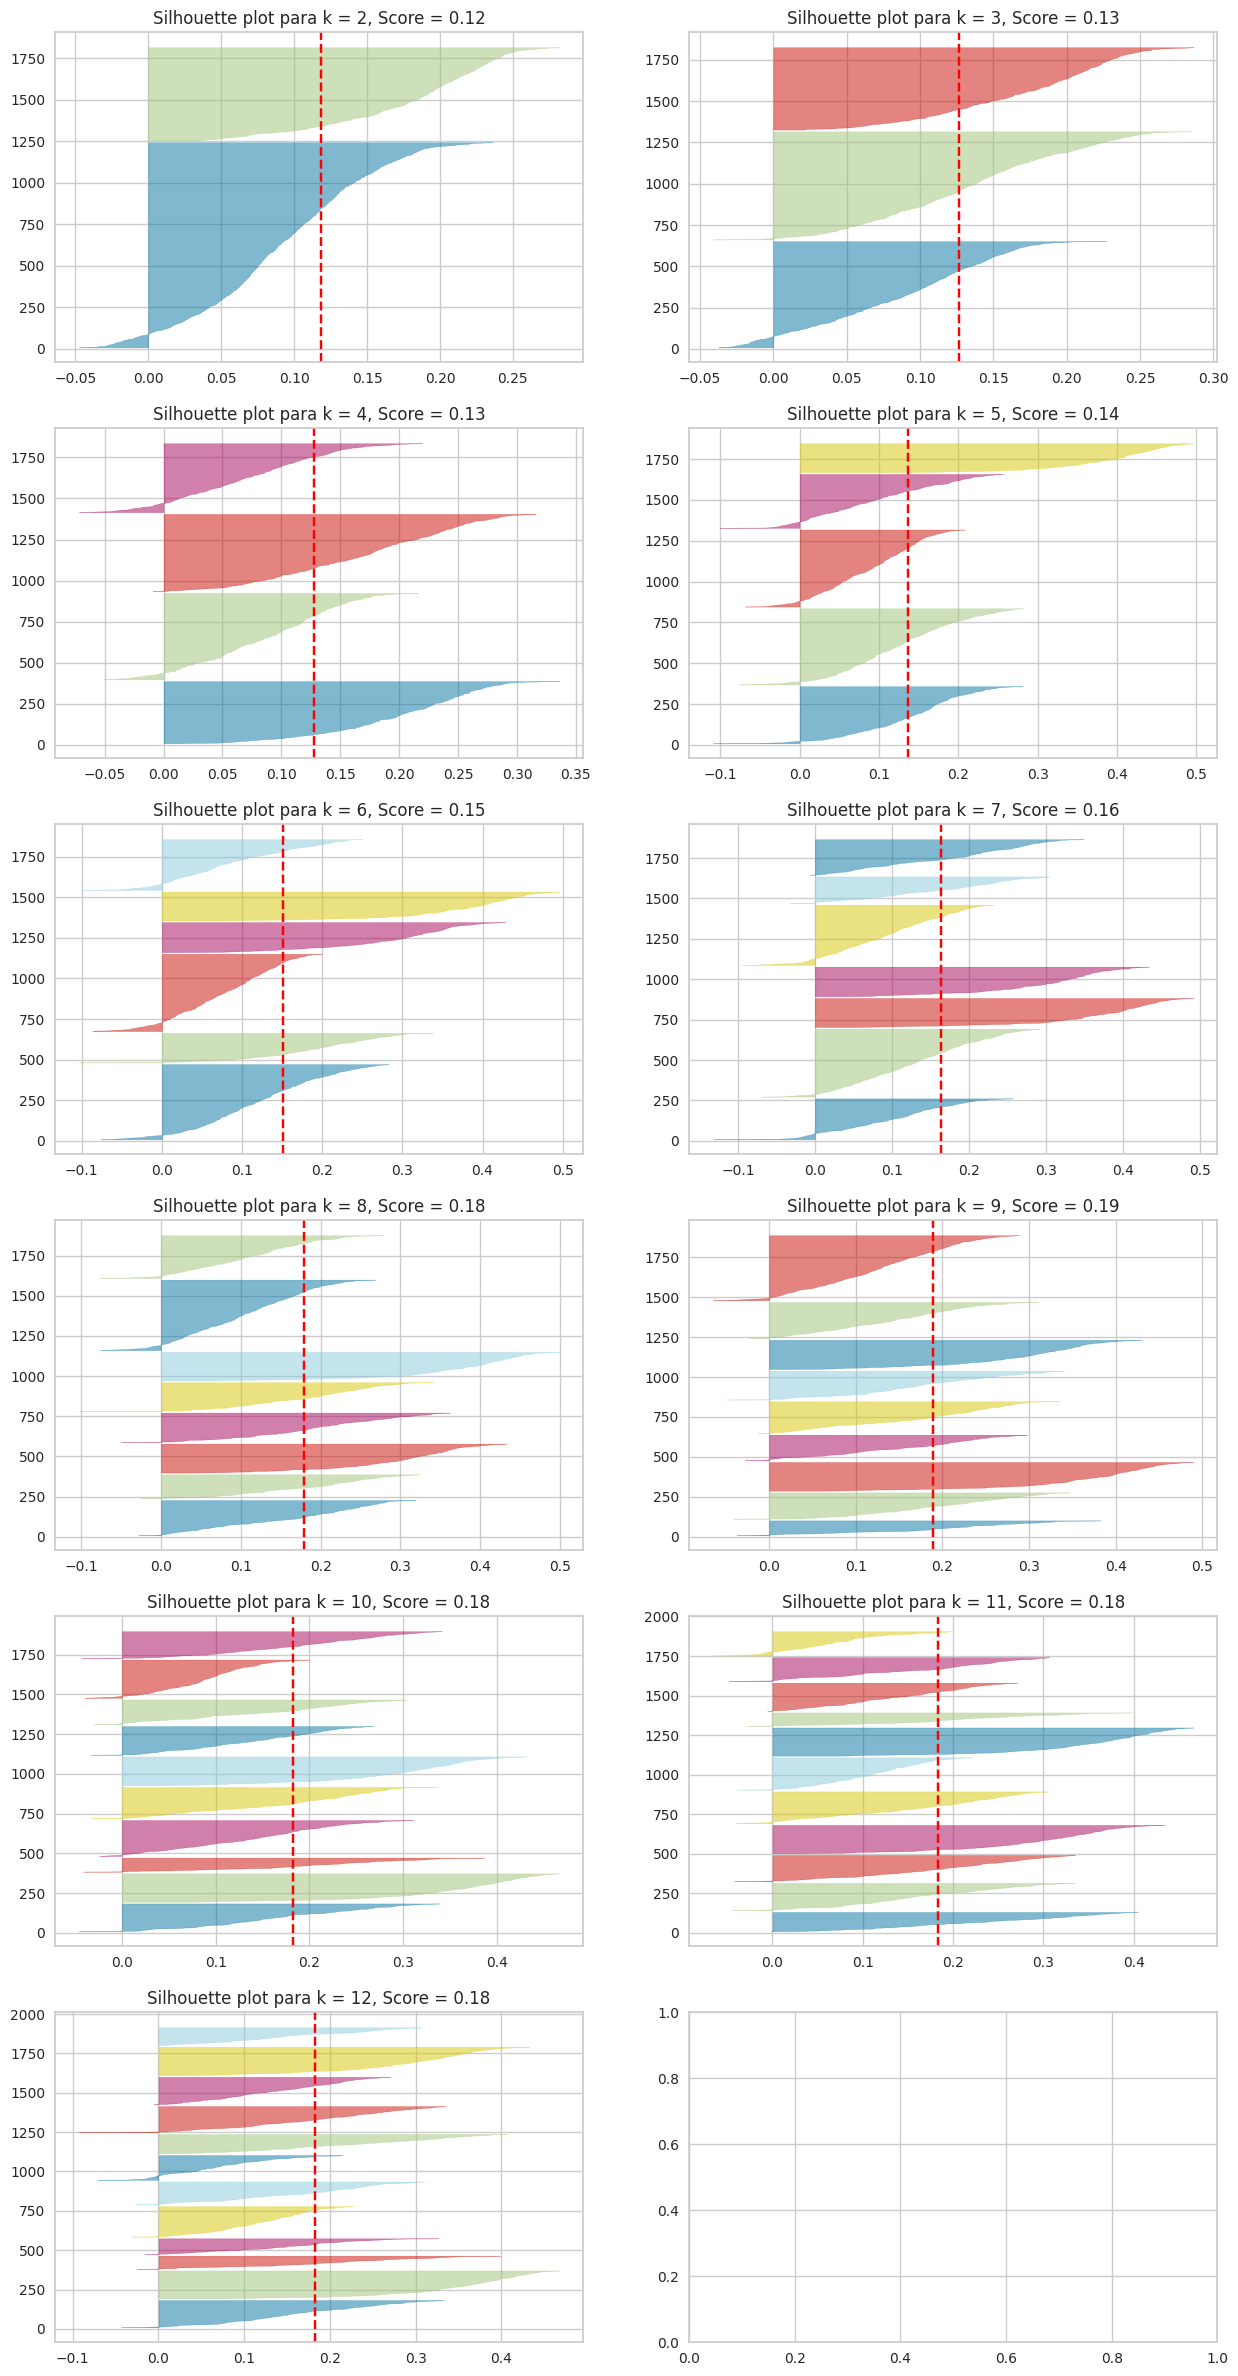

In [29]:


au.silhouette_plot(data,12)

Como tenemos 10 dígitos diferentes (del 0 al 9), vamos a agrupar las imágenes en 10 clústers

In [30]:
n = 10

Ejecutamos el modelo k-means

In [31]:
kmeans = KMeans(n_clusters=n,init='random')
kmeans.fit(data)
Z = kmeans.predict(data)

Mostramos los clústers resultantes del agrupamiento

cluster 0
208 elementos


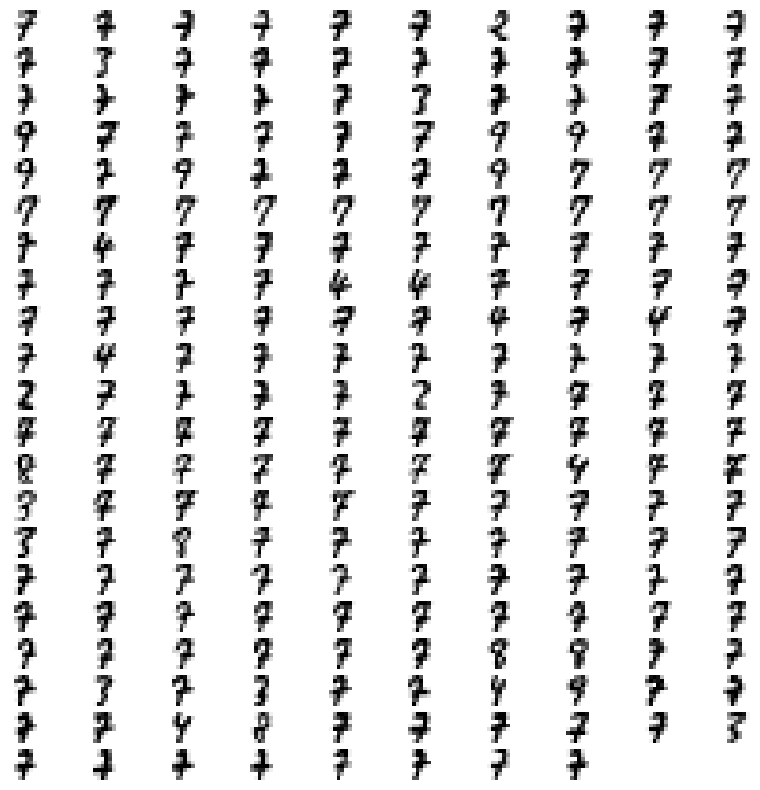

cluster 1
179 elementos


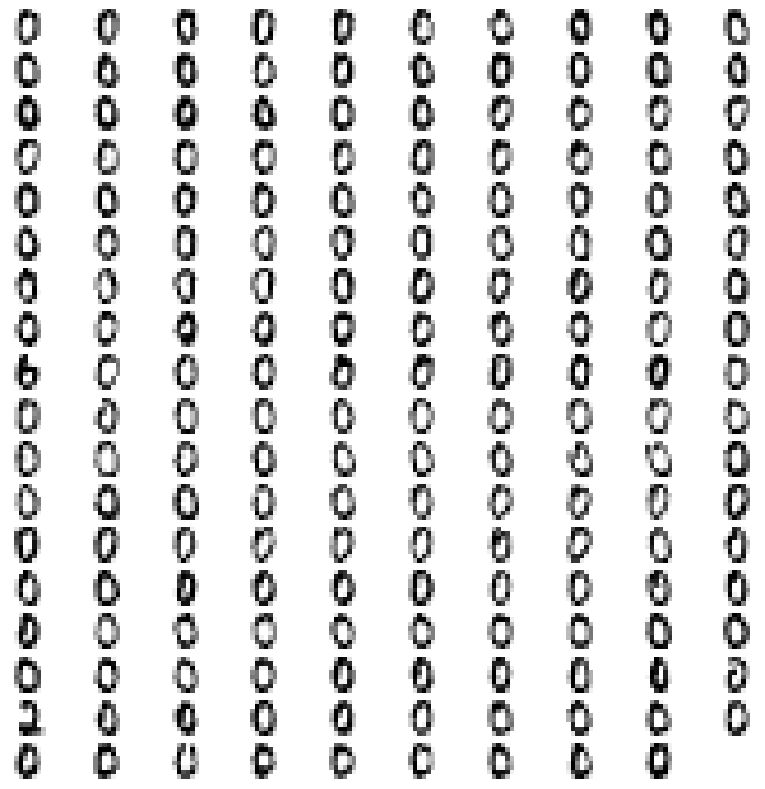

cluster 2
227 elementos


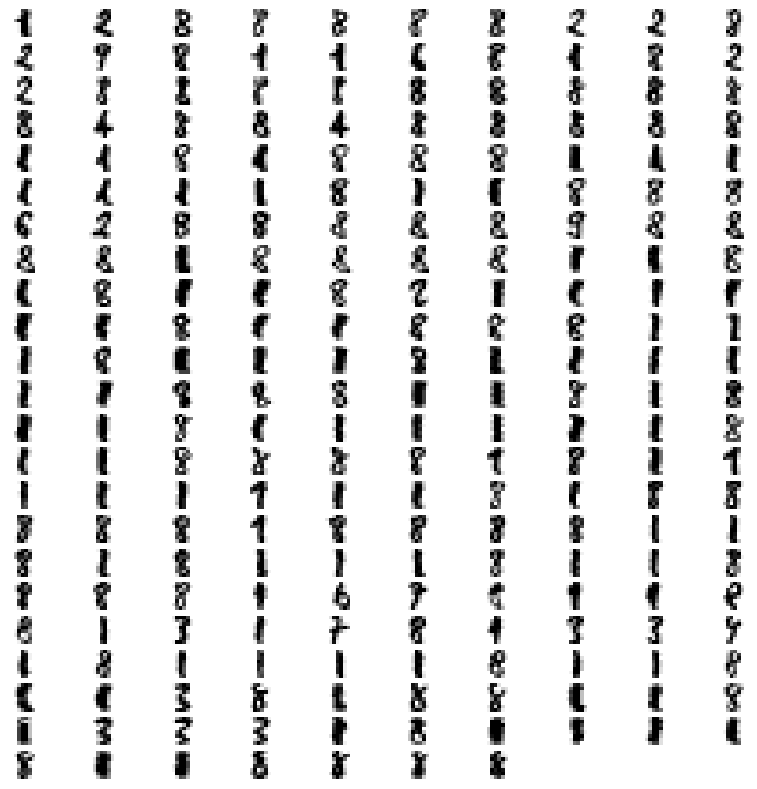

cluster 3
169 elementos


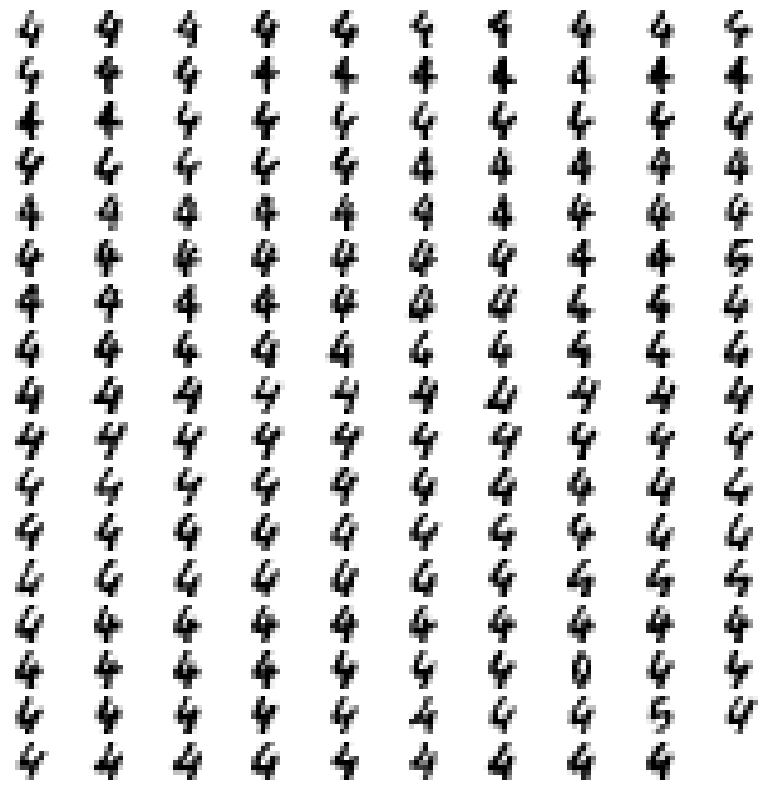

cluster 4
241 elementos


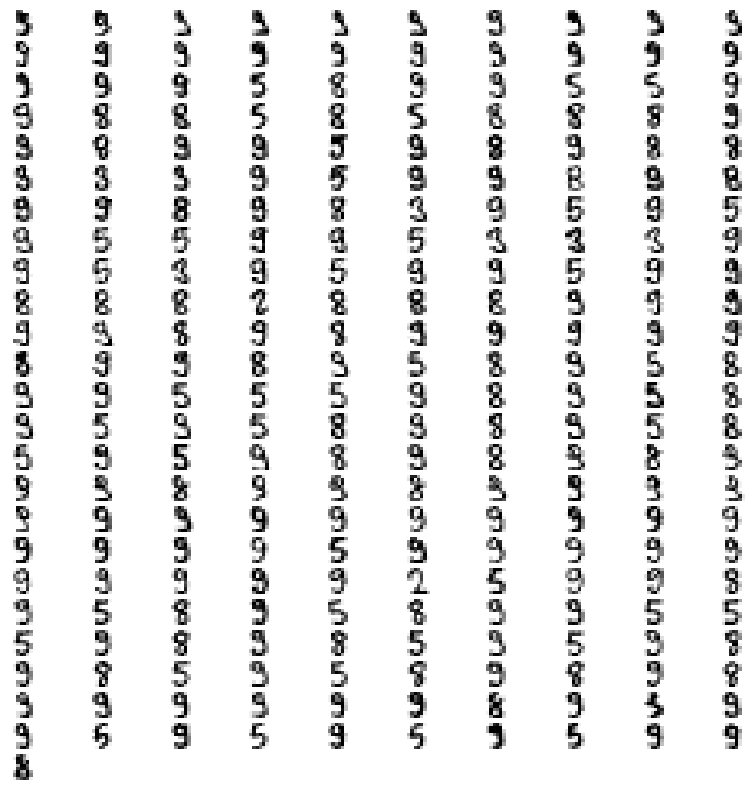

cluster 5
85 elementos


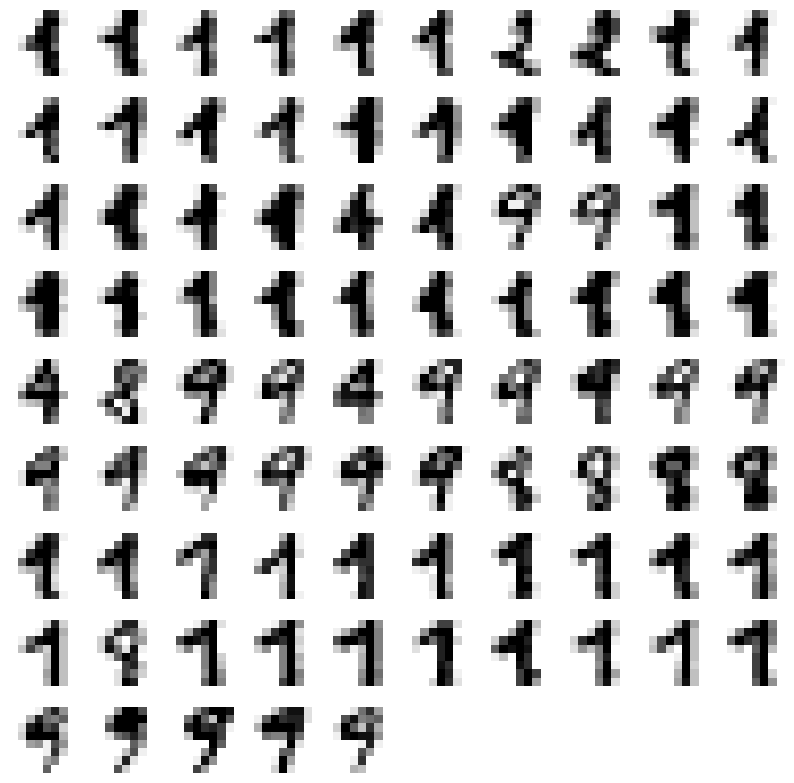

cluster 6
182 elementos


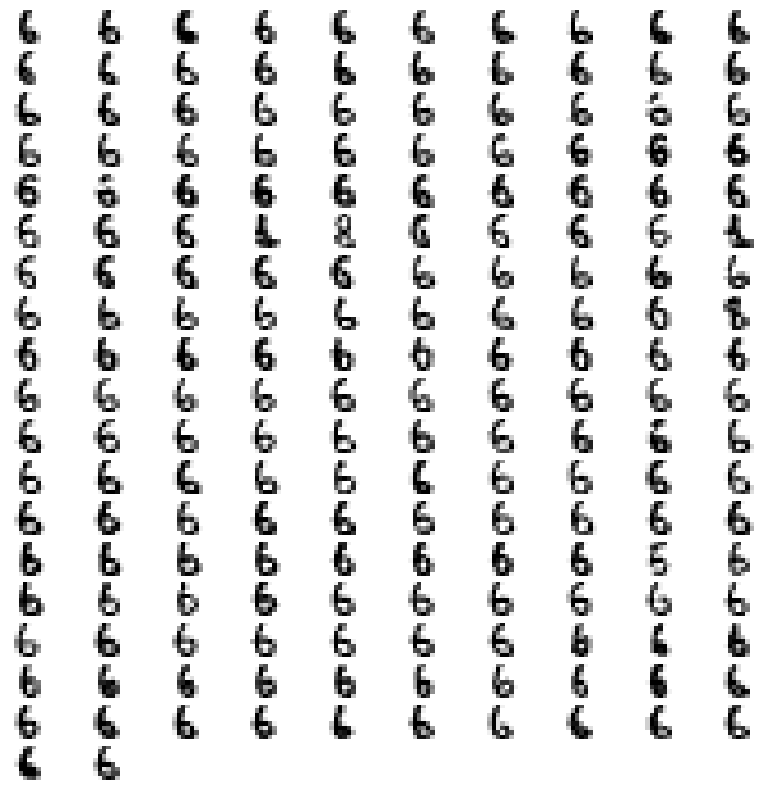

cluster 7
176 elementos


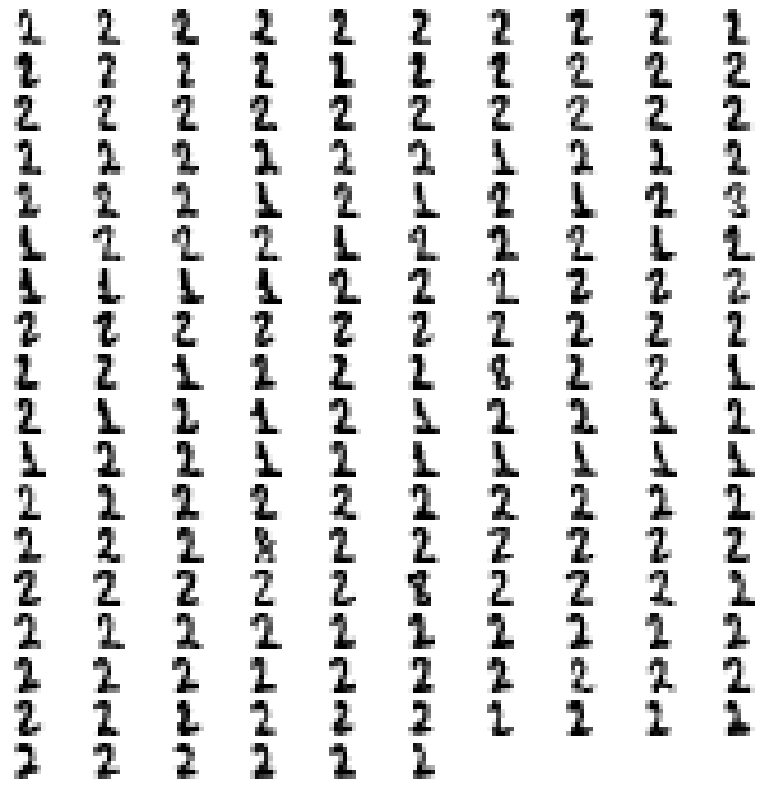

cluster 8
181 elementos


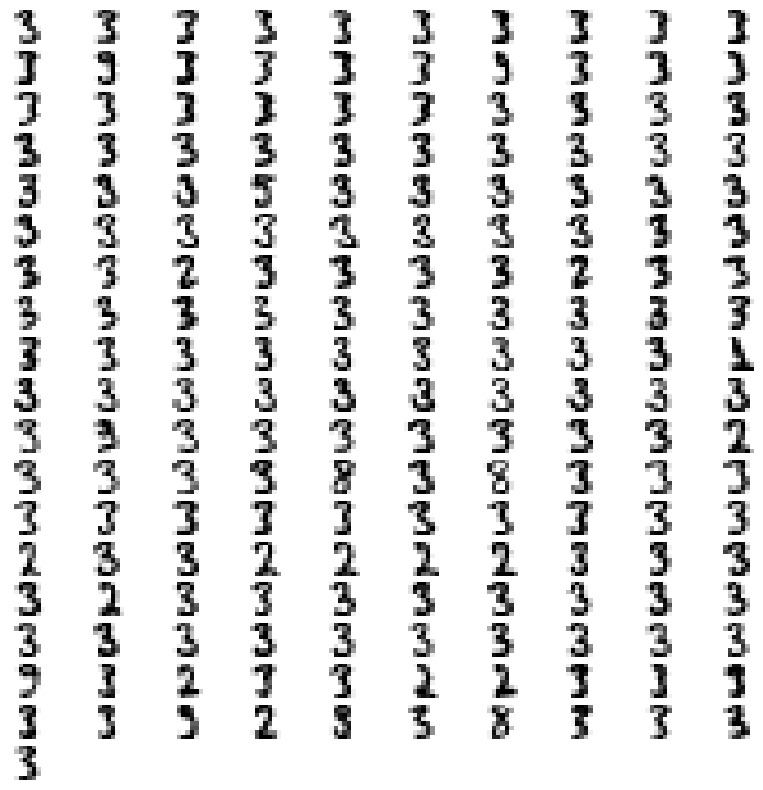

cluster 9
149 elementos


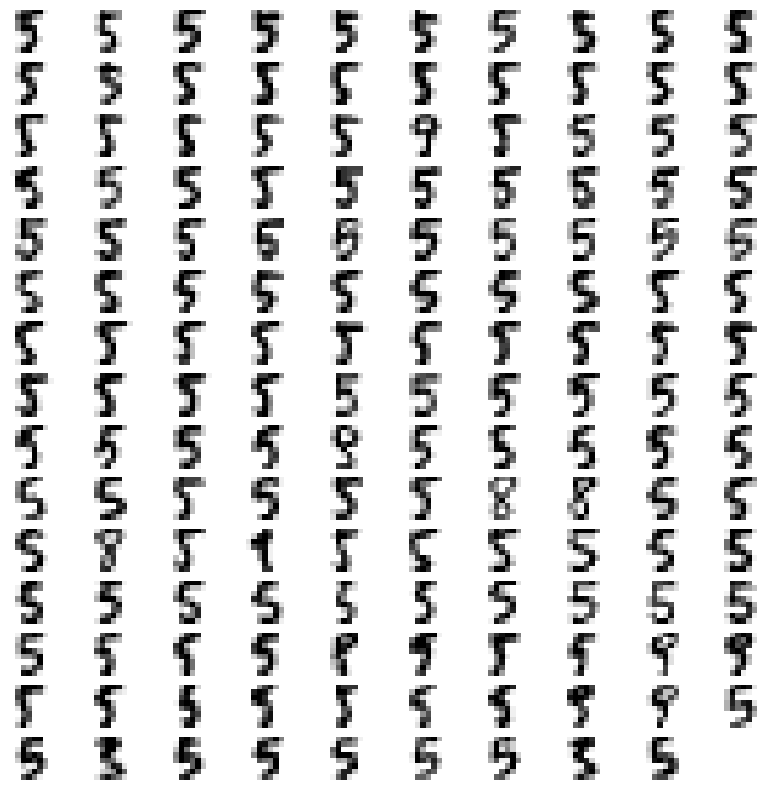

In [32]:
for i in range(0,n): # bucle para mostrar las imagenes de todos los clusters

    fila = np.where(Z==i)[0] # filas en Z donde están las imagenes de cada cluster
    num = fila.shape[0]      # número imagenes de cada cluster
    r = np.floor(num/10.)    # número de filas menos 1 en figura de salida 

    print("cluster "+str(i))
    print(str(num)+" elementos")

    plt.figure(figsize=(10,10))                 # tamaño de la figura
    for k in range(0, num):                     # bucle para mostrar las imagenes de cada cluster en una figura
        a = int(r+1)                            # número de filas en figura de salida
        b = int(k+1)                            # número de columnas en figura de salida
        plt.subplot(a, 10, b)
        imagen = data[fila[k], ]                # imagen a mostrar
        imagen = imagen.reshape(8, 8)           # rehacer la imagen a 8x8
        plt.imshow(imagen, cmap=plt.cm.gray)    # mostrar la imagen en escala de grises
        plt.axis('off')
    plt.show()

## EJERCICIO CLUSTERING CON K-MEANS   

Desde [Kaggle](https://www.kaggle.com/) selecciona y descargaa el dataset que más te interese para utilizar la técnica de K Means en él. Es probable que tengas que hacer una preparación previa de los datos.

Si no sabes que dataset utilizar, aquí tienes varias propuestas:

- [Customer Clustering](https://www.kaggle.com/datasets/dev0914sharma/customer-clustering?select=segmentation+data.csv) → Encuentra cuantos grupos de clientes tenemos para poder hacer campañas de márketing dirigidas.
- [Big Five Personality Test](https://www.kaggle.com/datasets/tunguz/big-five-personality-test) → Encuentra cuantos grupos de personalidad existen para poder hacer estudios psicológicos basándonos en estos grupos.
- [Countries Dataset 2020](https://www.kaggle.com/datasets/dumbgeek/countries-dataset-2020?rvi=1) → Encuentra que países son similares a España.
- [Wine Dataset for Clustering](https://www.kaggle.com/datasets/dumbgeek/countries-dataset-2020?rvi=1) → Encuentra cuentos tipos de vinos hay.